28

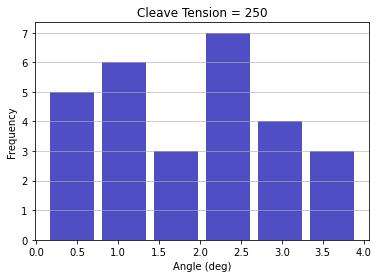

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import sklearn
import math
from sklearn.linear_model import LinearRegression
import os

n=6 #half the number of required cross sections (variable)
L=500 #size of data grid (Fixed)
c=50 #number of data points to clip for very steep fibers that are not covered completely by interference (variable)
theta = range(-45,45,90//(n)) #angle values determined by required number of cross sections
x_calc = np.zeros((L,n)) #initialise arrays
Y_raw = np.zeros((L,n))
Y_raw_inv = np.zeros((L,n))
Y_raw_rot = np.zeros((L,n))
clip = np.zeros((6))
surface = np.empty([501,501])
angles = []

# traverse whole directory
for root, dirs, files in os.walk(r'W:\Data\WG3\Cleaving Face\250'):
    # select file name
    for file in files:
        # get all the cross section files (.mat) and run code
        if file.endswith('.mat'):
            mat = scipy.io.loadmat(os.path.join(root, file)) #Load the data
            sorted(mat.keys()) #identify columns of data in the .mat file
            data = mat['Surface'] #extract the values for the surface height
            surface[:,:] = data
            for k in range(0,n): #k values determine each cross section form the angles in theta
                for i in range(0,L):
                    j = 250+((250-i)*math.tan(theta[k]*(math.pi/180))) #determine the values of x for each value of y depending on the angle of cross section
                    Y_raw[i,k] = surface[i,round(j)] #extract the surface height values for the cross section
                    Y_raw_inv[i,k] = surface[round(j),(L-i)] #extract the surface height values for the cross section
                Y_raw_rot[:,k] = np.flip(Y_raw_inv[:,k]) #flip data to preserve gradient direction
                clip[k] = round(np.count_nonzero(np.isnan(Y_raw[:,k]))/2) #count number of NAN values
                Y_raw[0:c+int(clip[k]),k] = np.NAN #clip data by amount depending on the angle (diagonal has more NAN than perpendicular)
                Y_raw[L-(c+int(clip[k])):L,k] = np.NAN
                Y_raw_rot[0:c+int(clip[k]),k] = np.NAN
                Y_raw_rot[L-(c+int(clip[k])):L,k] = np.NAN
                x_calc[:,k] = np.arange(0,(L*0.000329)/math.cos(theta[k]*(math.pi/180)),(L*0.000329)/math.cos(theta[k]*(math.pi/180))/L) #calculate the x value in real terms
            grad = []
            for angle in range(0,n): #arrange data and add a linear fit
                Y = Y_raw_rot[~np.isnan(Y_raw_rot[:,angle]),angle]
                Y_fdata = Y.reshape(-1,1)
                x_crop = np.arange(0,len(Y),1)
                x_fdata = x_crop.reshape(-1,1)
                regress = LinearRegression().fit(x_fdata*0.000329,Y_fdata)
                grad.append((180/math.pi)*(math.atan(regress.coef_[0][0]))) #build list of angle values
            for angle in range(0,n): #repeat for second set of cross sections
                Y = Y_raw[~np.isnan(Y_raw[:,angle]),angle]
                Y_fdata = Y.reshape(-1,1)
                x_crop = np.arange(0,len(Y),1)
                x_fdata = x_crop.reshape(-1,1)
                regress = LinearRegression().fit(x_fdata*0.000329,Y_fdata)
                grad.append((180/math.pi)*(math.atan(regress.coef_[0][0])))
            res = [abs(ele) for ele in grad]
            angles.append(max(res)) #take the maximum absolute angle and build a list for each file
# An "interface" to matplotlib.axes.Axes.hist() method
no, bins, patches = plt.hist(x=angles, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Angle (deg)');
plt.ylabel('Frequency');
plt.title('Cleave Tension = 250');
#plt.text(5, 5, r'$\mu=15, b=3$')
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(no.max() / 10) * 8 if no.max() % 4 else maxfreq + 2);
len(angles)